In [1]:
# import laybrarys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from pathlib import Path
from warnings import simplefilter
from scipy.signal import periodogram
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from plot_fig import *
from statsmodels.graphics.tsaplots import plot_pacf
simplefilter("ignore")


In [2]:
# read the orginal data from the csv file
df1 = pd.read_csv("well5.csv")
df1['date'] = pd.to_datetime(df1['date'], errors='coerce') #convert date column to datetime format
# =========================================
# create a dummy date time with freq = 1D to see which days we have no data
df = pd.DataFrame({
    'date': pd.date_range(start='2014-04-21', periods=717, freq='D')
})
# =========================================
# Merge on the 'date' column, using 'left' join to keep all dates from df1
df = df.merge(df1, on='date', how='left')
df.head()

,date,well_name,bhp,bht,dp_tubing,AVG_CHOKE_SIZE_P,thp,tht,choke_size_percentage,QL,QG,well6_inj,well7_inj
0,2014-04-21,15/9-F-15 D,199.786581,106.658980,155.118109,12.403833,44.668472,34.595614,15.978979,248.550000,38570.590000,5662.274117,4768.821610
1,2014-04-22,15/9-F-15 D,199.969739,106.652065,155.260995,12.310589,44.708743,32.657590,16.389120,237.410000,34001.500000,5789.492554,4247.453942
2,2014-04-23,15/9-F-15 D,199.773930,106.656580,155.136833,11.740151,44.637097,26.916889,16.291807,232.749277,33067.045161,6465.918884,5060.795754
3,2014-04-24,15/9-F-15 D,204.997626,106.290154,158.704731,10.226906,46.292896,24.877963,17.664526,234.543845,33552.408709,6158.800000,5236.800000
4,2014-04-25,15/9-F-15 D,199.749247,106.622406,154.847998,12.133490,44.901249,28.526759,16.262747,247.230000,35254.330000,6412.503662,5423.603912


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   717 non-null    datetime64[ns]
 1   well_name              591 non-null    object        
 2   bhp                    591 non-null    float64       
 3   bht                    591 non-null    float64       
 4   dp_tubing              591 non-null    float64       
 5   AVG_CHOKE_SIZE_P       591 non-null    float64       
 6   thp                    591 non-null    float64       
 7   tht                    591 non-null    float64       
 8   choke_size_percentage  591 non-null    float64       
 9   QL                     591 non-null    float64       
 10  QG                     591 non-null    float64       
 11  well6_inj              591 non-null    float64       
 12  well7_inj              591 non-null    float64       
dtypes: da

In [4]:
df.isna().sum()

date                       0
well_name                126
bhp                      126
bht                      126
dp_tubing                126
AVG_CHOKE_SIZE_P         126
thp                      126
tht                      126
choke_size_percentage    126
QL                       126
QG                       126
well6_inj                126
well7_inj                126
dtype: int64

In [5]:
df = df.loc[:, [
    "date", "bhp", "bht",
    "dp_tubing", "AVG_CHOKE_SIZE_P",
    "QG"
]]

df.head()

,date,bhp,bht,dp_tubing,AVG_CHOKE_SIZE_P,QG
0,2014-04-21,199.786581,106.658980,155.118109,12.403833,38570.590000
1,2014-04-22,199.969739,106.652065,155.260995,12.310589,34001.500000
2,2014-04-23,199.773930,106.656580,155.136833,11.740151,33067.045161
3,2014-04-24,204.997626,106.290154,158.704731,10.226906,33552.408709
4,2014-04-25,199.749247,106.622406,154.847998,12.133490,35254.330000


In [6]:
df.set_index('date', inplace=True)
df['Time'] = np.arange(len(df.index))
df = df.dropna()

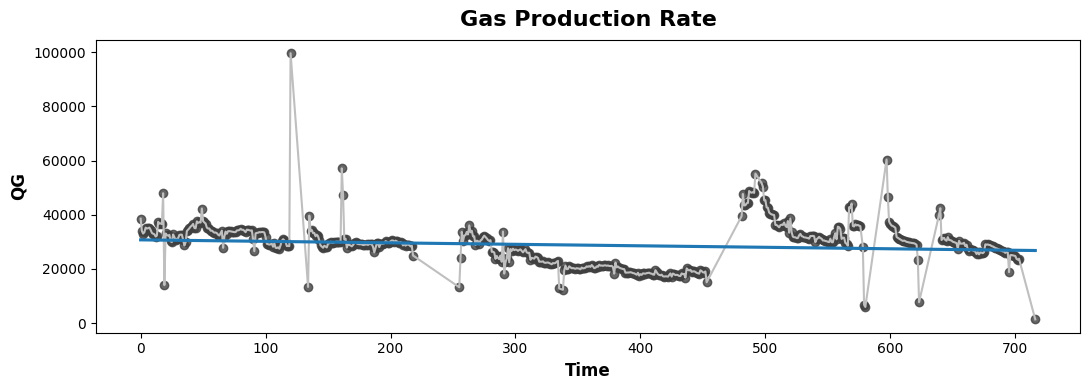

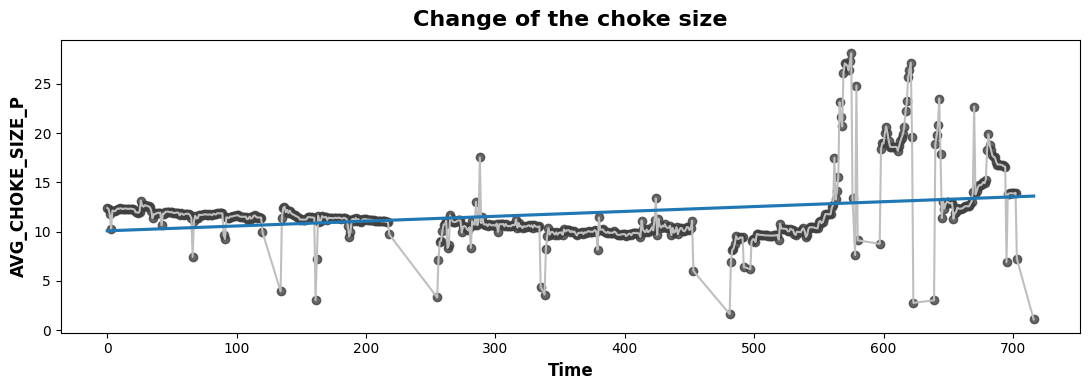

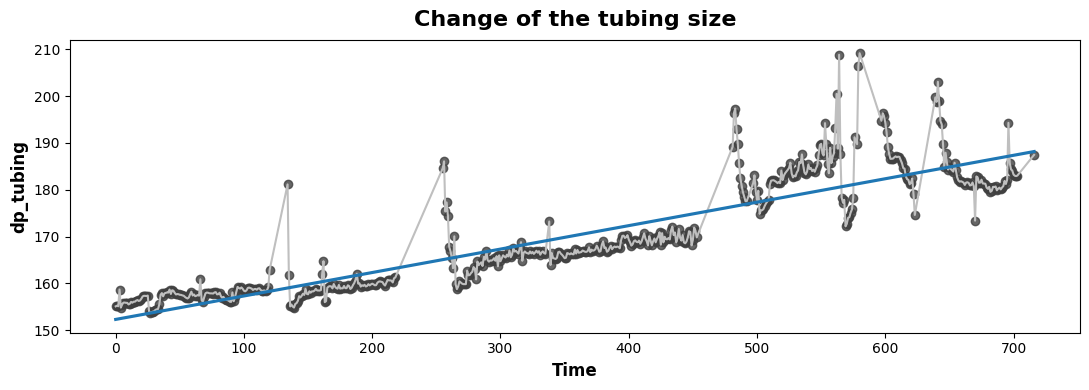

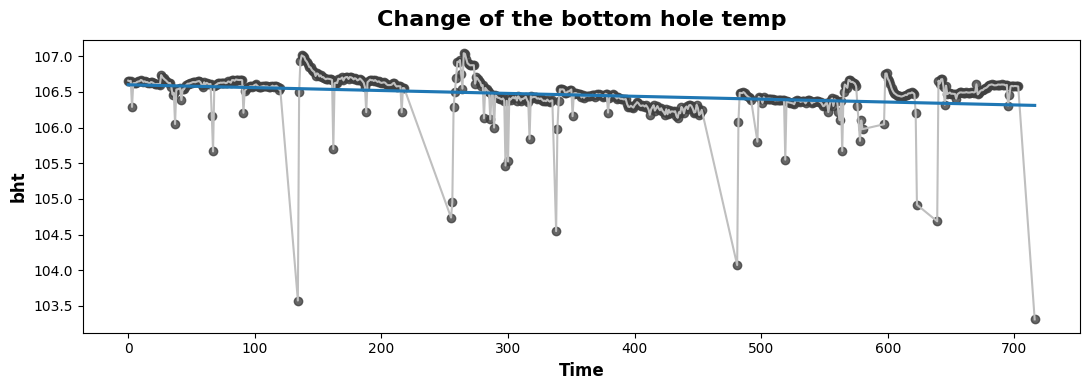

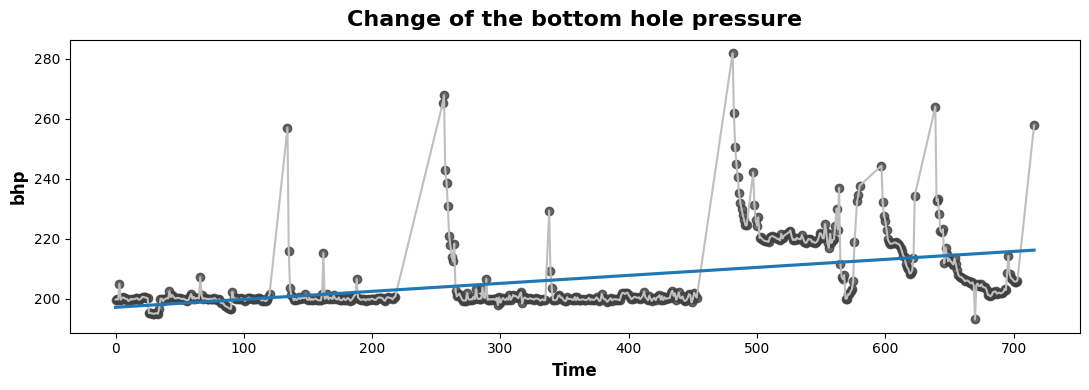

In [7]:
# Define a list of column names and their titles
plot_columns = [
    ('QG', 'Gas Production Rate'),
    ('AVG_CHOKE_SIZE_P', 'Change of the choke size'),
    ('dp_tubing', 'Change of the tubing size'),
    ('bht', 'Change of the bottom hole temp'),
    ('bhp', 'Change of the bottom hole pressure')
]

# Loop through each column and plot
for column, title in plot_columns:
    fig, ax = plt.subplots()
    ax.plot('Time', column, data=df, color='0.75')
    ax = sns.regplot(x='Time', y=column, data=df, ci=None, scatter_kws=dict(color='0.25'))
    ax.set_title(title)
    plt.show()

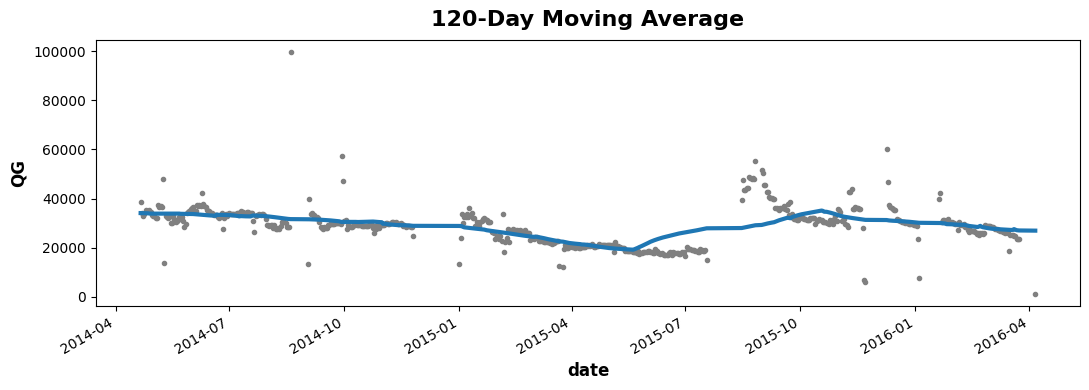

In [8]:
moving_average = df["QG"].rolling(
    window=120,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=30,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = df["QG"].plot(style=".", color="0.5")
ax.set_ylabel("QG")
moving_average.plot(
    ax=ax, linewidth=3, title="120-Day Moving Average", legend=False,
);

In [9]:
# add the lag
df["Lag_1"] = df["QG"].shift(1)
df.dropna(inplace=True)

In [10]:
X = df.copy()
y = X.pop("QG")

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

In [11]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y)
# mi_scores[::3]  # show a few features with their MI scores
mi_scores

Time                1.793790
Lag_1               1.783097
dp_tubing           1.110012
AVG_CHOKE_SIZE_P    1.022847
bht                 0.830835
bhp                 0.498872
Name: MI Scores, dtype: float64

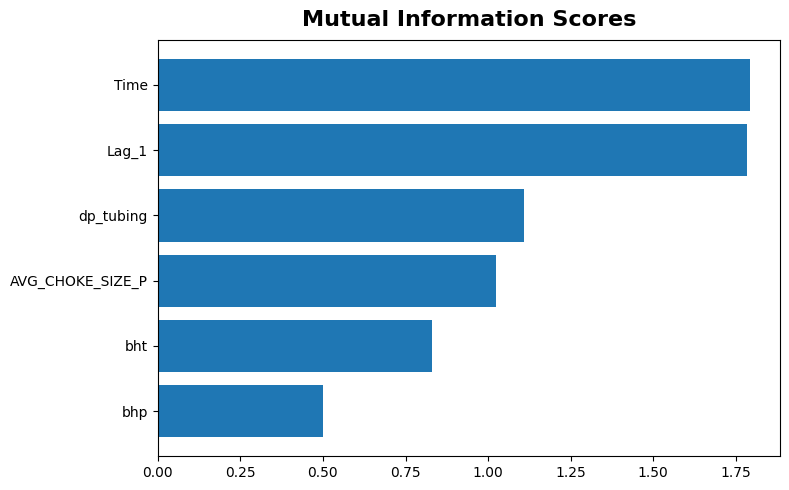

In [12]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [13]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')
# 'RdBu_r', 'BrBG_r', & PuOr_r are other good diverging colormaps

,bhp,bht,dp_tubing,AVG_CHOKE_SIZE_P,QG,Time,Lag_1
bhp,1.000000,-0.543479,0.745172,-0.098382,0.283028,0.468636,0.315965
bht,-0.543479,1.000000,-0.356232,0.363243,0.286447,-0.257879,0.134611
dp_tubing,0.745172,-0.356232,1.000000,0.246066,0.038169,0.894277,0.059061
AVG_CHOKE_SIZE_P,-0.098382,0.363243,0.246066,1.000000,0.154044,0.296158,0.173990
QG,0.283028,0.286447,0.038169,0.154044,1.000000,-0.141636,0.660956
Time,0.468636,-0.257879,0.894277,0.296158,-0.141636,1.000000,-0.135991
Lag_1,0.315965,0.134611,0.059061,0.173990,0.660956,-0.135991,1.000000


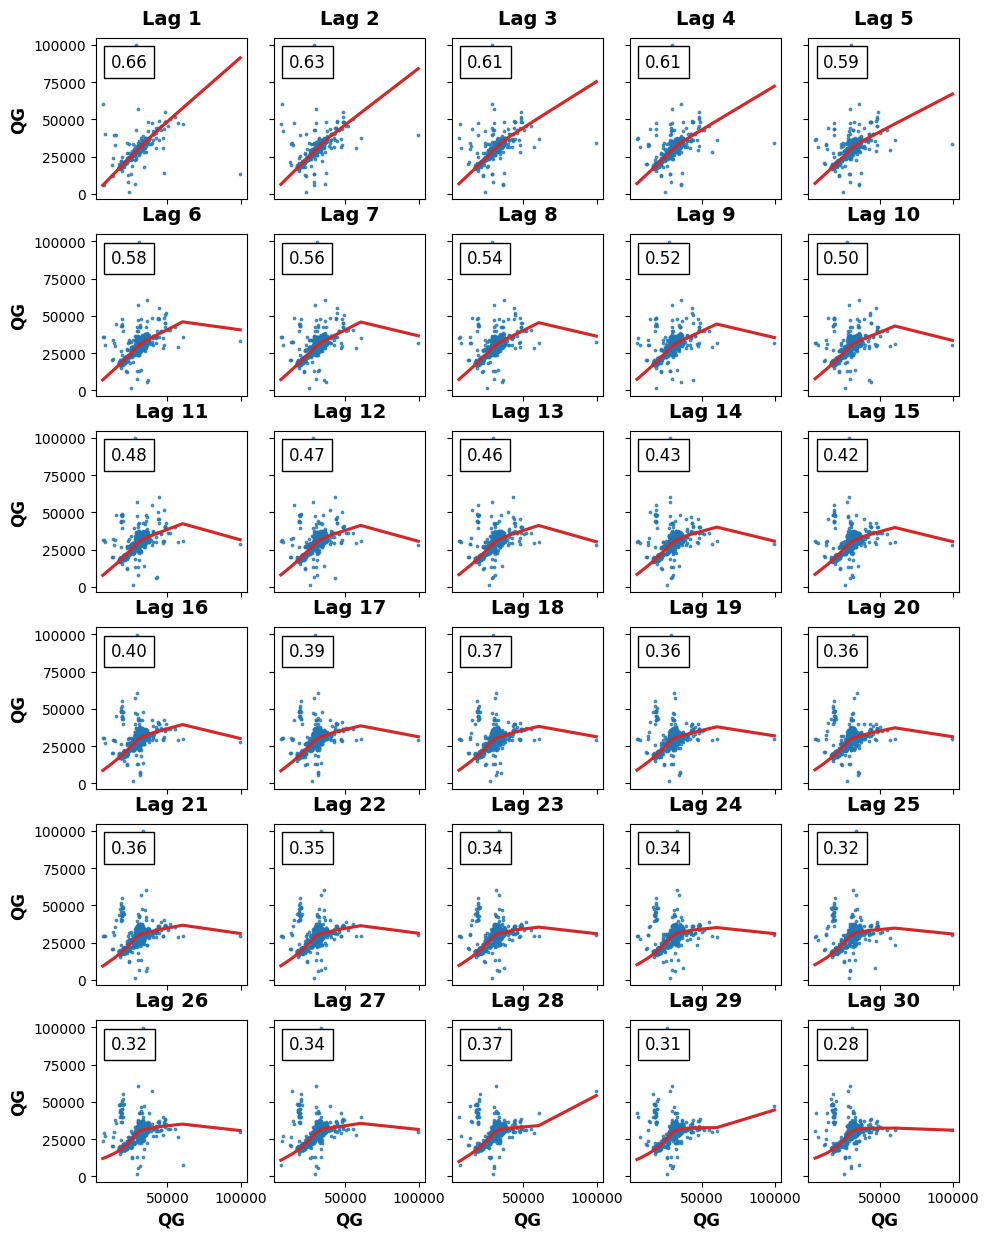

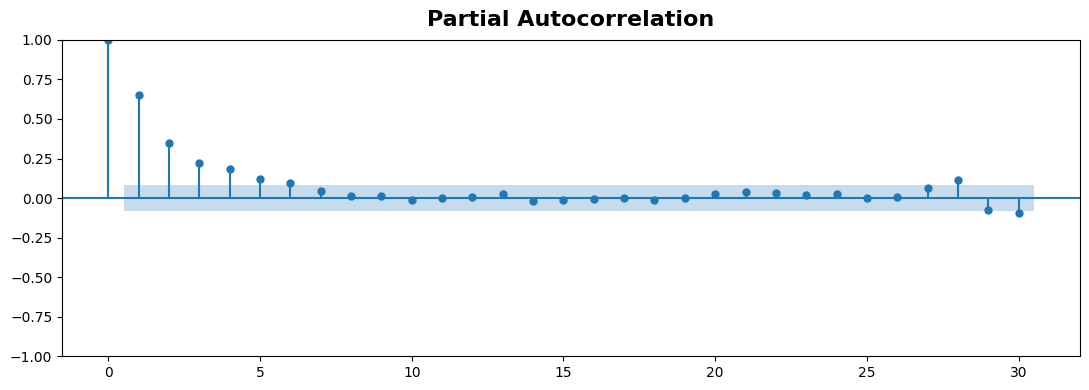

In [14]:
_ = plot_lags(df["QG"], lags=30, nrows=6)
_ = plot_pacf(df["QG"], lags=30)